# Question: Can SS-GNN distinguish graphs with different labels?
On the Circular Skip Link(CSL) data set we test whether SS-GNN can distinguihs graph of different labels. As the graphs for each label are different, the genreted k-subgraph distribution should be different. The encodings of those sampled subgraphs via. `SubgraphGNNEncoder`. If Weisfeiler-Lehman test can distinguish these subgraphs, GIN being equally expressive should induce same k-subgraph distribution as the WL encoder. **So the frequencies of distinguishable classes for subgraph encoder and GIN should be same** for a sampling of a given graph. The attention should also be able to distinguish two differe distributions.  <br>
First we observe what are the intra class and inter class distances for SS-GNN encodings.

## Library Import

In [1]:
import torch
import numpy as np
from torch_geometric.datasets import GNNBenchmarkDataset
from gps.utils.data_transform import SetNodeFeaturesOnes
from torch_geometric.loader import DataLoader

from uniform_sampler import sample_batch as sampler
import networkx as nx
import matplotlib.pyplot as plt

from gps.models.ss_gnn import SubgraphGNNEncoder, SubgraphSamplingGNNClassifier
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn.conv import GCNConv, GINConv
from torch_geometric.nn.pool import global_add_pool
import torch_geometric.nn as pyg

from torch_geometric.utils import scatter
import hashlib

## Model Definition

In [2]:
class VerboseSubgraphEncoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers, pooling='sum', residual=False,batch_norm=False):
        super().__init__()
        self.num_layers = num_layers
        self.residual = residual
        self.batch_norm = batch_norm
        self.proj = nn.Linear(in_dim,hidden_dim,bias=False)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            neural_net = self._make_neural_net(in_dim=hidden_dim, out_dim=hidden_dim)
            self.convs.append(GINConv(neural_net))
            if batch_norm:
                self.bns.append(pyg.BatchNorm(hidden_dim))
        if pooling == 'sum':
            self.pooling = pyg.global_add_pool
        self.activations = {}

    def forward(self, x, edge_index, batch):
        h = self.proj(x)
        self.activations['proj_0'] = h.clone()
        for l in range(self.num_layers):
            h_res = h
            h = self.convs[l](h,edge_index)
            self.activations[f'conv_{l}'] = h.clone()
            if self.batch_norm:
                h = self.bns[l](h)
                self.activations[f'bns_{l}'] = h.clone()
            if self.residual:
                h = h + h_res
                self.activations[f'res_{l}'] = h.clone()
        h_out = self.pooling(h,batch)
        self.activations['pooling'] = h_out.clone()
        return h_out
        
    def _make_neural_net(self, in_dim, out_dim, num_layers=2):
        layers = nn.ModuleList()
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers-1):
            layers.append(nn.Linear(out_dim, out_dim))
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)
        
class VerboseAttentionAggregator(nn.Module):
    def __init__(self, 
                 hidden_dim, 
                 temperature=0.2):
        super().__init__()
        self.temperature = temperature
        self.attention_mlp = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim//2),
        nn.ReLU(),
        nn.Linear(hidden_dim//2,1)
            )
        self.activations = {}
        
    def forward(self, subgraph_embeddings, batch):
        num_graphs = batch.max().item()+1
        scores = self.attention_mlp(subgraph_embeddings)
        scores = scores/self.temperature

        # find the max score along all subgraphs of each graph of the batch
        max_scores = scatter(scores, batch, dim=0, dim_size=num_graphs, reduce='max')
        # assign the corresponding max score to each subgraph of the batch
        max_scores = max_scores[batch]
        # e^{-(max_scores-scores)}
        scores_exp = torch.exp(scores-max_scores)
        # sum exp scores along each graph
        scores_sum = scatter(scores_exp, batch, dim=0, dim_size=num_graphs, reduce='sum')
        # boadcast socres_sums along each subgraph
        scores_sum = scores_sum[batch]
        # normalizing the scores_exp
        attention_weights = scores_exp / (scores_sum + 1e-8)
        
        '''scaling subgraph embeddings with sttention_weights
            attention_weights should prioritize significant subgraphs
            and scalling with attention weight should enhance (increase
            in magnitude) the important subgraph embeddings. 
        '''
        self.activations['attention_weights'] = attention_weights.clone()
        weighted_embeddings = attention_weights * subgraph_embeddings
        # finally, weighted sum for all subgraphs of each graph
        graphs_embeddings = scatter(weighted_embeddings, batch, dim=0, dim_size=num_graphs, reduce='sum')
        return graphs_embeddings

In [3]:
class VerboseModel(nn.Module):
    def __init__(self, 
                 in_dim, 
                 hidden_dim, 
                 num_layers, 
                 pooling='sum', 
                 residual=False, 
                 batch_norm=False, 
                 temperature=0.2):
        super().__init__()
        # components 
        self.encoder = VerboseSubgraphEncoder(in_dim, hidden_dim, num_layers, pooling, residual, batch_norm)
        self.aggregator = VerboseAttentionAggregator(hidden_dim,temperature)

        # activations for tracking
        self.activations = {}
    
    def forward(self, x, edge_index, subgraph_batch, num_graphs):
        '''Args:
            x: stacked attributes of all nodes
            edge_index: subgraph edge inedex
            subgraph_batch: parent graph id of each subgraph
            num_graphs: number of graphs present in the batch
        '''
        num_subgraphs = subgraph_batch.max()+1
        m = num_subgraphs//num_graphs

        subgraph_enc = self.encoder(x, edge_index, subgraph_batch)
        self.activations['subgraph_enc'] = subgraph_enc.clone()
        self.activations['encoder'] = self.encoder.activations

        graph_batch = torch.repeat_interleave(torch.arange(num_graphs, device=x.device), m)
        graph_enc = self.aggregator(subgraph_enc, graph_batch)
        self.activations['graph_enc'] = graph_enc.clone()
        self.activations['aggregator'] = self.aggregator.activations

        return graph_enc

## Utility Functions

In [4]:
def build_input(batch, k, m):
      '''Creates ss-gnn input from dataset batch'''
      device = batch.x.device
      num_subgraphs = (batch.batch.max()+1)*m
      nodes_sampled, edge_index_sampled, edge_ptr, sample_ptr, edge_src_global = \
          sampler(batch.edge_index.cpu(), batch.ptr.cpu(), m_per_graph=m, k=k)
      x_global = batch.x[nodes_sampled.flatten().to(device)]
      edge_index_global = torch.repeat_interleave(torch.arange(0,num_subgraphs), edge_ptr[1:]-edge_ptr[:-1])*k + edge_index_sampled  
      sample_id = torch.repeat_interleave(torch.arange(0,num_subgraphs), k)
      return x_global, edge_index_global.to(device), sample_id.to(device)

In [5]:
def wl_graph_hash_batch(edge_index, batch, node_features=None, num_iterations=3):
    """
    Compute WL hash for batched graphs.
    
    Args:
        edge_index: (2, num_edges) - edge indices
        batch: (num_nodes,) - batch assignment for each node
        node_features: (num_nodes, feature_dim) or None
        num_iterations: number of WL iterations
    
    Returns:
        hashes: list of hash strings, one per graph
    """
    num_nodes = batch.size(0)
    num_graphs = batch.max().item() + 1
    
    # Initialize labels
    if node_features is None:
        labels = torch.zeros(num_nodes, dtype=torch.long)
    else:
        labels = torch.tensor([hash(tuple(f.tolist())) % (2**31) 
                               for f in node_features], dtype=torch.long)
    
    # WL iterations
    for _ in range(num_iterations):
        new_labels = torch.zeros(num_nodes, dtype=torch.long)
        
        # Build adjacency for efficient neighbor lookup
        adj_dict = {i: [] for i in range(num_nodes)}
        for src, tgt in edge_index.t().tolist():
            adj_dict[src].append(tgt)
        
        for node in range(num_nodes):
            neighbors = adj_dict[node]
            if neighbors:
                neighbor_labels = labels[neighbors].sort()[0].tolist()
            else:
                neighbor_labels = []
            
            signature = str([labels[node].item()] + neighbor_labels)
            new_labels[node] = int(hashlib.md5(signature.encode()).hexdigest(), 16) % (2**31)
        
        labels = new_labels
    
    # Aggregate to graph-level hashes
    graph_hashes = []
    for g in range(num_graphs):
        mask = batch == g
        graph_labels = sorted(labels[mask].tolist())
        graph_sig = str(graph_labels)
        graph_hash = hashlib.md5(graph_sig.encode()).hexdigest()
        graph_hashes.append(graph_hash)
    
    return graph_hashes


In [6]:
def unique_with_epsilon(tensor, epsilon=1e-6, return_counts=False):
    """
    Find unique values in a tensor where values within epsilon are considered the same.
    
    Args:
        tensor: 1D PyTorch tensor
        epsilon: tolerance for considering values as equal
        return_counts: if True, also return counts for each unique value
    
    Returns:
        unique_values: Tensor of unique values
        counts (optional): Tensor of counts for each unique value
    """
    if len(tensor) == 0:
        if return_counts:
            return tensor, torch.tensor([], dtype=torch.long)
        return tensor
    
    # Sort the tensor
    sorted_tensor, _ = torch.sort(tensor)
    
    # Find where consecutive differences are greater than epsilon
    diffs = torch.diff(sorted_tensor)
    mask = torch.cat([torch.tensor([True]), diffs > epsilon])
    
    # Select unique values
    unique_values = sorted_tensor[mask]
    
    if return_counts:
        # Find cluster boundaries
        boundaries = torch.cat([torch.tensor([True]), diffs > epsilon, torch.tensor([True])])
        boundary_indices = torch.where(boundaries)[0]
        
        # Compute counts for each cluster
        counts = torch.diff(boundary_indices)
        
        return unique_values, counts
    
    return unique_values


## Load Activations
Load layerwise activations for observation.

In [7]:
data_dim = 5
hidden_dim = 64
k = 6
m = 100

# data
transform = SetNodeFeaturesOnes(dim=data_dim)
data = GNNBenchmarkDataset("./.temp/CSL", name='CSL', transform=transform)
loader = DataLoader(data,batch_size=15, shuffle=False)

# model
verbose_encoder = VerboseSubgraphEncoder(in_dim=5,hidden_dim=10, num_layers=4)
verbose_attention = VerboseAttentionAggregator(hidden_dim=10)

# trackers
enc_activations = []
agg_activations = []
subgraph_enc = []
graph_enc = []
labels = []
edge_indices = []
sample_ids = []

for batch in loader:
    y = batch.y
    num_graphs = batch.batch.max()+1
    
    x_global, edge_index_global, sample_id = build_input(batch, k, m)
    
    subgraph_encodings = verbose_encoder(x_global, edge_index_global, sample_id)
    
    graph_id = torch.repeat_interleave(torch.arange(num_graphs),m)
    graph_encodings = verbose_attention(subgraph_encodings,graph_id)

    edge_indices.append(edge_index_global)
    sample_ids.append(sample_id)
    enc_activations.append(verbose_encoder.activations)
    agg_activations.append(verbose_attention.activations)
    subgraph_enc.append(subgraph_encodings)
    graph_enc.append(graph_encodings)
    labels.append(y)


In [8]:
enc_activations_0 = enc_activations[0]
for key in enc_activations_0.keys():
    print(key,': ', enc_activations_0[key])

proj_0 :  tensor([[-0.1625,  0.8665,  0.4409,  ...,  0.6892,  0.0081, -0.2401],
        [-0.1625,  0.8665,  0.4409,  ...,  0.6892,  0.0081, -0.2401],
        [-0.1625,  0.8665,  0.4409,  ...,  0.6892,  0.0081, -0.2401],
        ...,
        [-0.1625,  0.8665,  0.4409,  ...,  0.6892,  0.0081, -0.2401],
        [-0.1625,  0.8665,  0.4409,  ...,  0.6892,  0.0081, -0.2401],
        [-0.1625,  0.8665,  0.4409,  ...,  0.6892,  0.0081, -0.2401]],
       grad_fn=<CloneBackward0>)
conv_0 :  tensor([[0.9370, 0.7529, 0.0000,  ..., 0.0000, 0.7021, 0.0000],
        [1.5378, 1.2373, 0.0000,  ..., 0.0000, 0.9770, 0.0000],
        [0.6378, 0.5094, 0.0000,  ..., 0.0000, 0.5667, 0.0000],
        ...,
        [0.6378, 0.5094, 0.0000,  ..., 0.0000, 0.5667, 0.0000],
        [0.9370, 0.7529, 0.0000,  ..., 0.0000, 0.7021, 0.0000],
        [0.6378, 0.5094, 0.0000,  ..., 0.0000, 0.5667, 0.0000]],
       grad_fn=<CloneBackward0>)
conv_1 :  tensor([[0.5845, 0.1757, 0.6892,  ..., 0.0000, 0.0000, 0.4302],
        

## Observation:
*   Convs diverge afer $l=1$
*   $l=2$ doesnot change, as seen with WL encoding

In [9]:
def show_stat(t, ep=0.0001):
    if isinstance(t, torch.Tensor):
        u, freq = unique_with_epsilon(t, epsilon=ep,return_counts=True)
        freq = freq.detach().numpy()
    else:
        u, freq = np.unique(t, return_counts=True)

    uniques = []
    for s in u:
        s = s[:4] if isinstance(s, str) else f'{s:0.5f}' 
        uniques.append(s)

    print(f'\tNum Uniq: {len(uniques)}')
    print(f'\tUniques: \n\t{uniques}')
    print(f'\tFrequency: \n\t{freq}')

**Observation for label 0**:

In [10]:
for key in enc_activations_0.keys():
    value = enc_activations_0[key]
    dist = torch.cdist(value, value)
    print(f"\n\n{key}:")
    show_stat(dist[0], ep=0.0001)

print(f"\n\nsubgraph_enc:")
dist = torch.cdist(subgraph_enc[0], subgraph_enc[0])
show_stat(dist[0],ep=0.0001)

print(f'\n\ngraph_enc:')
dist = torch.cdist(graph_enc[0], graph_enc[0])
show_stat(dist[0], ep=0.003)



proj_0:
	Num Uniq: 1
	Uniques: 
	['0.00000']
	Frequency: 
	[9000]


conv_0:
	Num Uniq: 5
	Uniques: 
	['0.00000', '0.00035', '0.46467', '0.46693', '0.93866']
	Frequency: 
	[4307    4 3581 1047   61]


conv_1:
	Num Uniq: 18
	Uniques: 
	['0.00049', '0.00986', '0.04223', '0.09409', '0.09789', '0.10682', '0.10843', '0.19226', '0.19397', '0.20594', '0.20701', '0.29008', '0.30832', '0.33645', '0.39239', '0.43664', '0.49116', '0.58903']
	Frequency: 
	[  52  108  360   35  788  339   60  572 1266  110  148 1490   30   35
  157   26 1327 2097]


conv_2:
	Num Uniq: 31
	Uniques: 
	['0.00000', '0.00774', '0.01885', '0.03911', '0.06132', '0.06402', '0.06860', '0.07168', '0.07629', '0.11748', '0.12489', '0.12698', '0.14051', '0.16822', '0.17324', '0.17956', '0.18466', '0.18933', '0.24681', '0.26942', '0.27615', '0.29540', '0.29621', '0.31639', '0.35626', '0.37732', '0.39386', '0.39754', '0.43095', '0.44907', '0.45992']
	Frequency: 
	[  52  108   60  148  220  360   60  231   26  110  360   35  108 

In [11]:
for i in range(len(subgraph_enc)):
    print('='*20)
    print(f'Graphs of Label -> {i}')
    print('='*20)
    wl_encoding = wl_graph_hash_batch(edge_indices[i],sample_ids[i],num_iterations=3)
    print('Weisfeiler Lehman Encoding')
    show_stat(wl_encoding)
    dist = torch.cdist(subgraph_enc[i], subgraph_enc[i])
    print('0th Graph POV')
    show_stat(dist[0],ep=0.0003)

Graphs of Label -> 0
Weisfeiler Lehman Encoding
	Num Uniq: 8
	Uniques: 
	['03ed', '289f', '304c', '6e70', '7524', 'c118', 'dfbf', 'e3e8']
	Frequency: 
	[ 53 188 599  87 189  55 283  46]
0th Graph POV
	Num Uniq: 9
	Uniques: 
	['0.00000', '0.00138', '1.22038', '1.57931', '2.52268', '3.13266', '3.51274', '5.63396', '7.87981']
	Frequency: 
	[548  51 283 189  53 188  55  87  46]
Graphs of Label -> 1
Weisfeiler Lehman Encoding
	Num Uniq: 13
	Uniques: 
	['03ed', '304c', '30c8', '381b', '4985', '581b', '5dd1', '73bc', '9dae', 'a8b3', 'bc02', 'e08f', 'f15b']
	Frequency: 
	[ 36 530  16  20  34  30  81  26  92  93 327 188  27]
0th Graph POV
	Num Uniq: 14
	Uniques: 
	['0.00000', '0.00138', '0.20963', '0.26234', '0.42774', '0.66914', '1.19407', '1.41610', '1.45931', '1.68009', '2.52268', '2.91658', '3.15177', '4.48162']
	Frequency: 
	[466  64 327  81  16  34 188  93  92  27  36  26  30  20]
Graphs of Label -> 2
Weisfeiler Lehman Encoding
	Num Uniq: 12
	Uniques: 
	['03ed', '304c', '30c8', '4985', '5

## Wasserstein Distance of Subgraph Distributions
Take two graphs from different classes. Find out the Wasserstein Distance between the subgraph embedding of distributions of those two graphs. 

In [7]:
def wasserstein_distance(embd1, embd2, epsilon=0.1, num_iters=100):
    '''
    Approximate Wasserstein distance using Sinkhorn algorithm
    Fully differentiable and works on GPU
    
    Args:
        embd1, embd2: [m, d] tensors
        epsilon: regularization parameter (smaller -> more accurate but slower)
        num_iteration: number of Sinkhorn iterations
    '''
    m1, m2 = embd1.shape[0], embd2.shape[0]
    # Uniform distributions 
    a = torch.ones(m1, device=embd1.device) / m1
    b = torch.ones(m2, device=embd2.device) / m2

    # Pairwise squared distances 
    C = torch.cdist(embd1, embd2, p=2) ** 2 # [m1, m2]

    # Sinkhorn iterations 
    K = torch.exp(-C / epsilon)
    u = torch.ones_like(a)
    v = torch.ones_like(b)

    for _ in range(num_iters):
        u = a / (K @ v + 1e-8)
        v = a / (K.t() @ u + 1e-8)

    # Compute optimal transport plan
    pi = u.unsqueeze(1) * K * v.unsqueeze(0)

    # Wasserstein distance 
    W = (pi * C).sum()

    return W

In [13]:
dist1 = subgraph_enc[0][:100]
dist2 = subgraph_enc[1][:100]

In [14]:
wasserstein_distance(dist1,dist2, epsilon=0.001)

tensor(0.0018, grad_fn=<SumBackward0>)

In [15]:
wasserstein_distance(dist1,dist1, epsilon=0.001)

tensor(3.4973e-07, grad_fn=<SumBackward0>)

In [19]:
for i in range(len(subgraph_enc)):
    for j in range(len(subgraph_enc)):
        print(f"({i},{j}): {wasserstein_distance(subgraph_enc[i],subgraph_enc[j],epsilon=0.001): .5f}")

(0,0):  0.00000
(0,1):  0.00274
(0,2):  0.00310
(0,3):  0.00220
(0,4):  0.00207
(0,5):  0.00217
(0,6):  0.00219
(0,7):  0.00205
(0,8):  0.00350
(0,9):  0.00211
(1,0):  0.00274
(1,1):  0.00006
(1,2):  0.00060
(1,3):  0.00013
(1,4):  0.00007
(1,5):  0.00008
(1,6):  0.00007
(1,7):  0.00008
(1,8):  0.00086
(1,9):  0.00008
(2,0):  0.00310
(2,1):  0.00063
(2,2):  0.00007
(2,3):  0.00034
(2,4):  0.00032
(2,5):  0.00027
(2,6):  0.00035
(2,7):  0.00023
(2,8):  0.00034
(2,9):  0.00024
(3,0):  0.00220
(3,1):  0.00014
(3,2):  0.00013
(3,3):  0.00007
(3,4):  0.00008
(3,5):  0.00008
(3,6):  0.00008
(3,7):  0.00007
(3,8):  0.00044
(3,9):  0.00014
(4,0):  0.00207
(4,1):  0.00007
(4,2):  0.00010
(4,3):  0.00007
(4,4):  0.00007
(4,5):  0.00008
(4,6):  0.00007
(4,7):  0.00008
(4,8):  0.00040
(4,9):  0.00008
(5,0):  0.00217
(5,1):  0.00008
(5,2):  0.00014
(5,3):  0.00008
(5,4):  0.00008
(5,5):  0.00007
(5,6):  0.00010
(5,7):  0.00007
(5,8):  0.00045
(5,9):  0.00007
(6,0):  0.00219
(6,1):  0.00007
(6,2):  

## Conclusion 
Graphs with different label has different subgraph embeding distribution, as Wasserstein distance is $>\epsilon$ graph label $i,j (i \neq j)$, for some $\epsilon>0$. So mean pooling of the subgraph embeddings shuld result different encodings for graphs of different label. Classifier with aggregation might learn to distinguish graphs of differnt label.

# Training the (Verbose)SS-GNN

## Goal: Test if Verbose SS-GNN can learn on CSL

**Observation from analysis above**: 
- Graphs with different labels have **different subgraph embedding distributions** (Wasserstein distance > 0)
- This suggests the model SHOULD be able to distinguish them

**Hypothesis**: 
- The VerboseSSGNN (our debug implementation) CAN learn on CSL
- If it succeeds → bug is in the original SS-GNN implementation
- If it fails → need to investigate architecture/hyperparameters

**Baseline**: 
- Random guess accuracy = 10% (10 classes)
- Vanilla GNN typically achieves ~10% on CSL (cannot distinguish 1-WL equivalent graphs)

In [17]:
# create dataloader
# create Model
# create optimizer, loss and metric functions
# For training epoches:
#   for each batch calculate the loss and back propagate 
#   calculate averate loss over the batches 
# For testing epoches: 
#   calucate average metric over the batches 

In [7]:
data_dim = 5
hidden_dim = 64
k = 6
m = 100

# data
transform = SetNodeFeaturesOnes(dim=data_dim)
data = GNNBenchmarkDataset("./.temp/CSL", name='CSL', transform=transform)
loader = DataLoader(data,batch_size=15, shuffle=False)

verbose_model = VerboseModel(data_dim,hidden_dim,5)

optimizer = torch.optim.AdamW(verbose_model.parameters(), lr=0.001)


In [8]:
# Create train/test split
from sklearn.model_selection import train_test_split

indices = list(range(len(data)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=[d.y.item() for d in data])

train_data = [data[i] for i in train_idx]
test_data = [data[i] for i in test_idx]

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Class distribution
train_labels = [d.y.item() for d in train_data]
test_labels = [d.y.item() for d in test_data]
print(f"\nTrain class distribution: {np.bincount(train_labels)}")
print(f"Test class distribution: {np.bincount(test_labels)}")

Train samples: 120
Test samples: 30

Train class distribution: [12 12 12 12 12 12 12 12 12 12]
Test class distribution: [3 3 3 3 3 3 3 3 3 3]


In [9]:
# Add classifier head to VerboseModel
class VerboseSSGNN(nn.Module):
    def __init__(self, 
                 in_dim, 
                 hidden_dim, 
                 num_layers,
                 num_classes,
                 pooling='sum', 
                 residual=False, 
                 batch_norm=False, 
                 temperature=0.2):
        super().__init__()
        # Get the base model
        self.base_model = VerboseModel(in_dim, hidden_dim, num_layers, pooling, residual, batch_norm, temperature)
        
        # Add classifier head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x, edge_index, subgraph_batch, num_graphs):
        graph_enc = self.base_model(x, edge_index, subgraph_batch, num_graphs)
        logits = self.classifier(graph_enc)
        return logits

# Test it
test_model = VerboseSSGNN(data_dim, hidden_dim, 5, num_classes=10)
print(test_model)

VerboseSSGNN(
  (base_model): VerboseModel(
    (encoder): VerboseSubgraphEncoder(
      (proj): Linear(in_features=5, out_features=64, bias=False)
      (convs): ModuleList(
        (0-4): 5 x GINConv(nn=Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
        ))
      )
      (bns): ModuleList()
    )
    (aggregator): VerboseAttentionAggregator(
      (attention_mlp): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [10]:
# Training function
def train_epoch(model, loader, optimizer, criterion, k, m, device='cpu'):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in loader:
        batch = batch.to(device)
        num_graphs = batch.batch.max().item() + 1
        
        # Build SS-GNN input
        x_global, edge_index_global, sample_id = build_input(batch, k, m)
        
        # Forward pass
        logits = model(x_global, edge_index_global, sample_id, num_graphs)
        
        # Compute loss
        loss = criterion(logits, batch.y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * num_graphs
        pred = logits.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += num_graphs
    
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy

In [11]:
# Evaluation function
@torch.no_grad()
def evaluate(model, loader, criterion, k, m, device='cpu'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for batch in loader:
        batch = batch.to(device)
        num_graphs = batch.batch.max().item() + 1
        
        # Build SS-GNN input
        x_global, edge_index_global, sample_id = build_input(batch, k, m)
        
        # Forward pass
        logits = model(x_global, edge_index_global, sample_id, num_graphs)
        
        # Compute loss
        loss = criterion(logits, batch.y)
        
        # Track metrics
        total_loss += loss.item() * num_graphs
        pred = logits.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
        total += num_graphs
        
        all_preds.extend(pred.cpu().tolist())
        all_labels.extend(batch.y.cpu().tolist())
    
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

In [12]:
# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
data_dim = 5
hidden_dim = 64
num_layers = 5
num_classes = 10
k = 6  # subgraph size
m = 100  # samples per graph
num_epochs = 50
lr = 0.001

# Model
model = VerboseSSGNN(
    in_dim=data_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_classes=num_classes,
    pooling='sum',
    residual=False,
    batch_norm=False,
    temperature=0.2
).to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Using device: cuda

Model parameters: 48,843
Trainable parameters: 48,843


In [13]:
# Training loop with monitoring
print("="*60)
print("Starting Training")
print("="*60)

best_test_acc = 0
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, k, m, device)
    
    # Evaluate
    test_loss, test_acc, preds, labels = evaluate(model, test_loader, criterion, k, m, device)
    
    # Track history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Update best
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_epoch = epoch
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

print("="*60)
print(f"Training Complete!")
print(f"Best Test Accuracy: {best_test_acc*100:.2f}% (Epoch {best_epoch+1})")
print("="*60)

Starting Training
Epoch   1/50 | Train Loss: 2.3111 | Train Acc: 7.50% | Test Loss: 2.2909 | Test Acc: 10.00%
Epoch   5/50 | Train Loss: 1.9914 | Train Acc: 18.33% | Test Loss: 1.9090 | Test Acc: 30.00%
Epoch  10/50 | Train Loss: 1.7635 | Train Acc: 26.67% | Test Loss: 1.7404 | Test Acc: 30.00%
Epoch  15/50 | Train Loss: 1.8289 | Train Acc: 25.00% | Test Loss: 1.9885 | Test Acc: 20.00%
Epoch  20/50 | Train Loss: 1.7776 | Train Acc: 24.17% | Test Loss: 1.8815 | Test Acc: 26.67%
Epoch  25/50 | Train Loss: 1.6846 | Train Acc: 35.83% | Test Loss: 1.6837 | Test Acc: 33.33%
Epoch  30/50 | Train Loss: 1.6738 | Train Acc: 30.00% | Test Loss: 1.7814 | Test Acc: 26.67%
Epoch  35/50 | Train Loss: 1.6752 | Train Acc: 33.33% | Test Loss: 1.6731 | Test Acc: 30.00%
Epoch  40/50 | Train Loss: 1.7166 | Train Acc: 31.67% | Test Loss: 1.7367 | Test Acc: 30.00%
Epoch  45/50 | Train Loss: 1.6981 | Train Acc: 28.33% | Test Loss: 1.6981 | Test Acc: 30.00%
Epoch  50/50 | Train Loss: 1.7552 | Train Acc: 28.33%

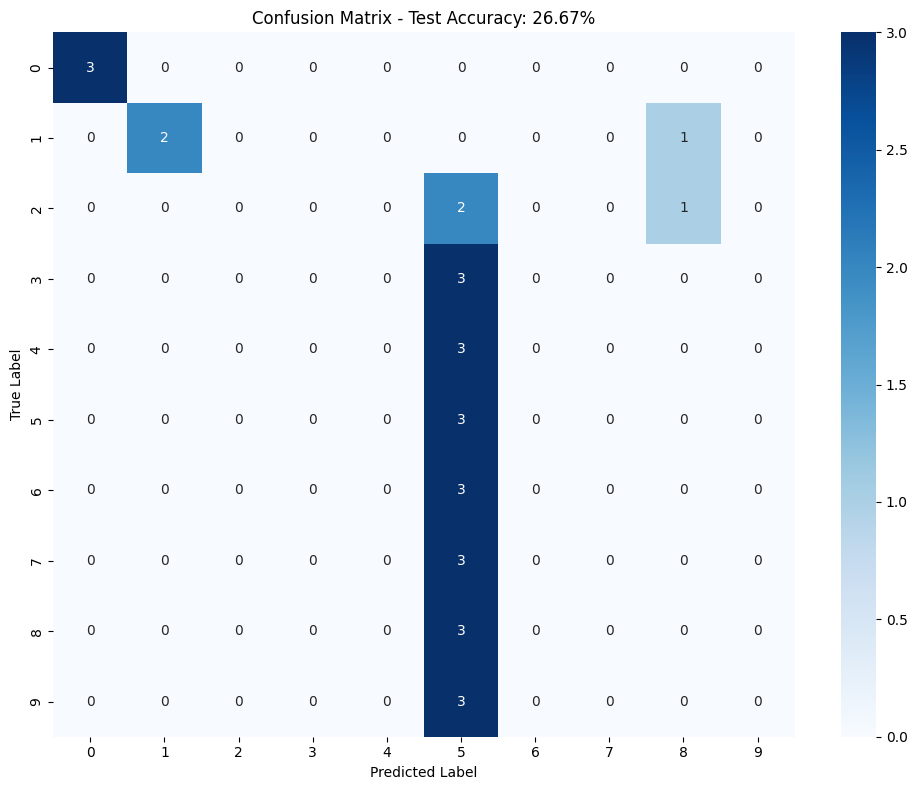


Per-class accuracy:
  Class 0: 100.0% (3/3)
  Class 1: 66.7% (2/3)
  Class 2: 0.0% (0/3)
  Class 3: 0.0% (0/3)
  Class 4: 0.0% (0/3)
  Class 5: 100.0% (3/3)
  Class 6: 0.0% (0/3)
  Class 7: 0.0% (0/3)
  Class 8: 0.0% (0/3)
  Class 9: 0.0% (0/3)


In [14]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get final predictions
_, _, final_preds, final_labels = evaluate(model, test_loader, criterion, k, m, device)

# Compute confusion matrix
cm = confusion_matrix(final_labels, final_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - Test Accuracy: {test_accs[-1]*100:.2f}%')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
for i in range(10):
    if cm[i].sum() > 0:
        class_acc = cm[i, i] / cm[i].sum() * 100
        print(f"  Class {i}: {class_acc:.1f}% ({cm[i, i]}/{cm[i].sum()})")

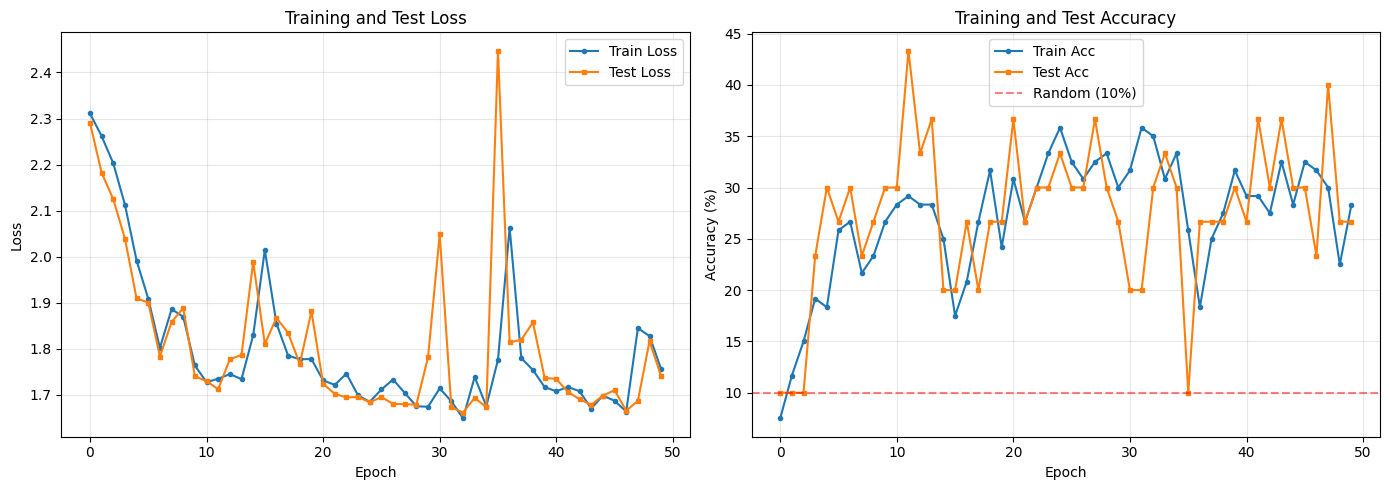


Final Results:
  Train Accuracy: 28.33%
  Test Accuracy: 26.67%
  Best Test Accuracy: 43.33% (Epoch 12)

  Random baseline: 10.00%
  Improvement over random: 16.67 percentage points


In [15]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(train_losses, label='Train Loss', marker='o', markersize=3)
ax1.plot(test_losses, label='Test Loss', marker='s', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot([acc*100 for acc in train_accs], label='Train Acc', marker='o', markersize=3)
ax2.plot([acc*100 for acc in test_accs], label='Test Acc', marker='s', markersize=3)
ax2.axhline(y=10, color='r', linestyle='--', label='Random (10%)', alpha=0.5)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Train Accuracy: {train_accs[-1]*100:.2f}%")
print(f"  Test Accuracy: {test_accs[-1]*100:.2f}%")
print(f"  Best Test Accuracy: {best_test_acc*100:.2f}% (Epoch {best_epoch+1})")
print(f"\n  Random baseline: 10.00%")
print(f"  Improvement over random: {(test_accs[-1]-0.1)*100:.2f} percentage points")